In [1]:
import glob
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import shapely
import matplotlib.colors as colors
from IPython.display import clear_output
from tqdm.notebook import tqdm
import time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_34693/223714492.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# https://34c031f8-c9fd-4018-8c5a-4159cdff6b0d-cdn-endpoint.azureedge.net/-/media/calfire-website/what-we-do/fire-resource-assessment-program---frap/historic-fire-perimeters-data-dictionary_updatedjune2023.pdf?rev=cf22c8e76e9d4d3998f9b5f2bef01df0&hash=DBCCF699AAAECAF981C13FC51BD9B2A1
file_list = ['./fire22_1.gdb/a000000af.gdbtable',
             './fire22_1.gdb/a000000b8.gdbtable',
             './fire22_1.gdb/a000000b9.gdbtable',
             './fire22_1.gdb/a000000ba.gdbtable',]

In [21]:
fires = geopandas.GeoDataFrame()
for filename in tqdm(file_list):
    fires_temp = geopandas.read_file(filename)
    fires_temp = fires_temp.to_crs('epsg:4326')
    fires = geopandas.GeoDataFrame(pd.concat([fires, fires_temp], ignore_index=True))
    

month = []
year = []
alarm = fires["ALARM_DATE"].notnull()
cont = fires["CONT_DATE"].notnull()
start = fires["START_DATE"].notnull()
end = fires["END_DATE"].notnull()
for i in tqdm(range(len(fires))):
    date = ""
    if (alarm[i]):
        date = fires["ALARM_DATE"][i]
    elif (cont[i]):
        date = fires["CONT_DATE"][i]
    elif (start[i]):
        date = fires["START_DATE"][i]
    elif (end[i]):
        date = fires["END_DATE"][i]
    if (date == ""):
        month.append(np.nan)
        year.append(np.nan)
    else:
        date = str(date)
        month.append(int(date.split("-")[1]))
        year.append(int(date.split("-")[0]))
fires["MONTH"] = month
fires["YEAR"] = year
fires = fires[~fires.duplicated()]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/53351 [00:00<?, ?it/s]

In [24]:
sums = 0
for i in tqdm(range(len(fires))):
    if ((not alarm[i]) and (not cont[i]) and (not start[i]) and (not end[i])):
        sums += 1
sums

  0%|          | 0/48425 [00:00<?, ?it/s]

11184

In [5]:
fires.columns

Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM',
       'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'COMMENTS', 'REPORT_AC',
       'GIS_ACRES', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'Shape_Length',
       'Shape_Area', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'IRWINID', 'geometry',
       'TREATMENT_ID', 'TREATMENT_NAME', 'START_DATE', 'END_DATE',
       'TREATED_AC', 'RX_CONSUM', 'PRE_CON_CLASS', 'POST_CON_CLASS',
       'TREATMENT_TYPE', 'MONTH', 'YEAR'],
      dtype='object')

In [23]:
print("Missing Data Points")
for column in fires.columns:
    print(column + ": " + str(fires[column].isnull().sum()))

Missing Data Points
YEAR_: 136
STATE: 1
AGENCY: 10
UNIT_ID: 55
FIRE_NAME: 9330
INC_NUM: 10592
ALARM_DATE: 15269
CONT_DATE: 29733
CAUSE: 9348
COMMENTS: 13434
REPORT_AC: 38963
GIS_ACRES: 2
C_METHOD: 28870
OBJECTIVE: 9663
FIRE_NUM: 17856
Shape_Length: 0
Shape_Area: 0
COMPLEX_NAME: 47274
COMPLEX_INCNUM: 47355
IRWINID: 47733
geometry: 0
TREATMENT_ID: 39387
TREATMENT_NAME: 40283
START_DATE: 41523
END_DATE: 41285
TREATED_AC: 39909
RX_CONSUM: 47105
PRE_CON_CLASS: 47671
POST_CON_CLASS: 47671
TREATMENT_TYPE: 41234
MONTH: 6925
YEAR: 6925


In [25]:
np.mean(fires.loc[(fires["YEAR_"] >= "2000") & (fires["YEAR_"] <= "2019")]["GIS_ACRES"])/20

76.68625650518518

In [26]:
np.sum(fires.loc[(fires["YEAR_"] >= "2000") & (fires["YEAR_"] <= "2019")]["GIS_ACRES"])/20

1385413.9100226755

In [27]:
len(fires.loc[(fires["YEAR_"] >= "2000") & (fires["YEAR_"] <= "2019")])/20

903.3

In [30]:
fires.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,...,TREATMENT_NAME,START_DATE,END_DATE,TREATED_AC,RX_CONSUM,PRE_CON_CLASS,POST_CON_CLASS,TREATMENT_TYPE,MONTH,YEAR
0,2020,CA,CDF,NEU,NELSON,00013212,2020-06-18T00:00:00,2020-06-23T00:00:00,11.0,,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2020.0
1,2020,CA,CDF,NEU,AMORUSO,00011799,2020-06-01T00:00:00,2020-06-04T00:00:00,2.0,,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2020.0
2,2020,CA,CDF,NEU,ATHENS,00018493,2020-08-10T00:00:00,2020-08-11T00:00:00,14.0,,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,8.0,2020.0
3,2020,CA,CDF,NEU,FLEMING,00007619,2020-03-31T00:00:00,2020-04-01T00:00:00,9.0,,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2020.0
4,2020,CA,CDF,NEU,MELANESE,00008471,2020-04-14T00:00:00,2020-04-19T00:00:00,18.0,,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2020.0


9852

903.3

In [7]:
np.unique(fires["CAUSE"])

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 18., 19., nan])

In [45]:
world = geopandas.read_file('/Users/christopher/Downloads/ark28722-s73w23-geojson.json')

In [13]:
fires.loc[fires["CAUSE"] == 12]["GIS_ACRES"]

7281      210.065674
14455    1954.705933
14781     411.792023
14785     317.940216
14787      75.596115
37842     210.065674
45016    1954.705933
45342     411.792023
45346     317.940216
45348      75.596115
Name: GIS_ACRES, dtype: float64

<IPython.core.display.Javascript object>


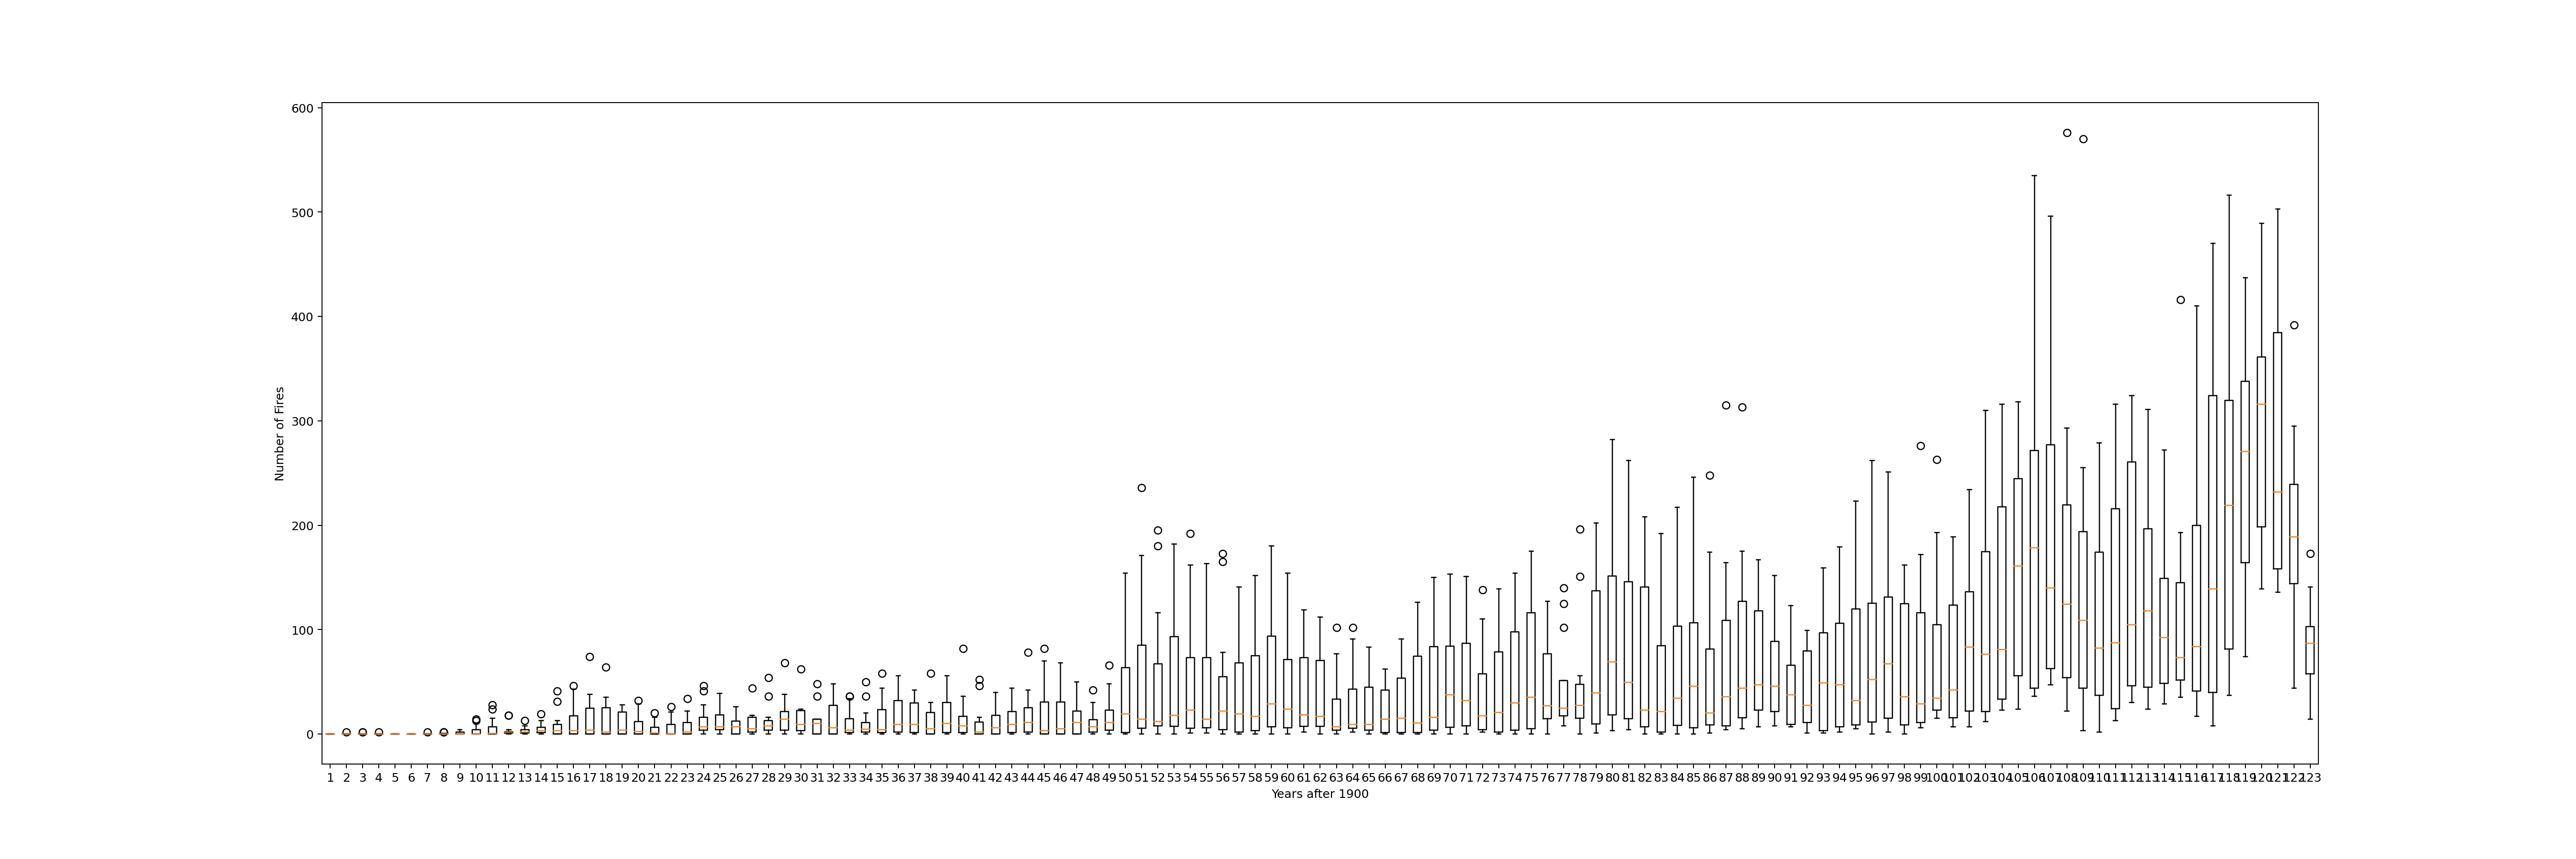

In [69]:
boxplot_data = []
for year in range(1900,2023, 1):
    plot_data = []
    for month in range(1, 13):
        plot_data.append(len(fires.loc[(fires["YEAR"] >= year) & (fires["YEAR"] < 2+year) & (fires["MONTH"] == month)]))
    boxplot_data.append(plot_data)

fig, ax = plt.subplots(figsize = (30,10))
ax.boxplot(boxplot_data)
ax.set_xlabel("Years after 1900")
ax.set_ylabel("Number of Fires")
plt.show()

<IPython.core.display.Javascript object>


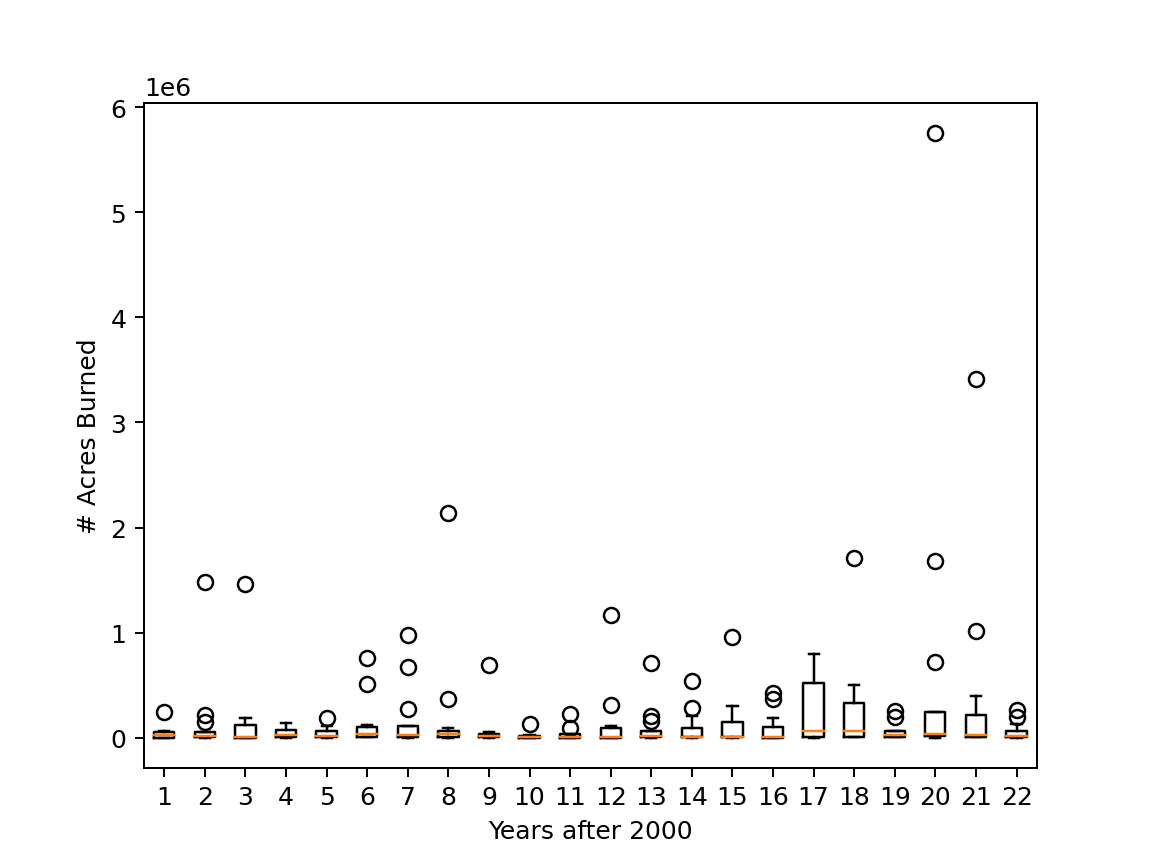

In [70]:
boxplot_data = []
for year in range(2001,2023):
    plot_data = []
    for month in range(1, 13):
        plot_data.append(np.sum(fires.loc[(fires["YEAR"] == year) & (fires["MONTH"] == month)]["GIS_ACRES"]))
    boxplot_data.append(plot_data)

fig, ax = plt.subplots()
ax.boxplot(boxplot_data)
ax.set_xlabel("Years after 2000")
ax.set_ylabel("# Acres Burned")
plt.show()

<IPython.core.display.Javascript object>


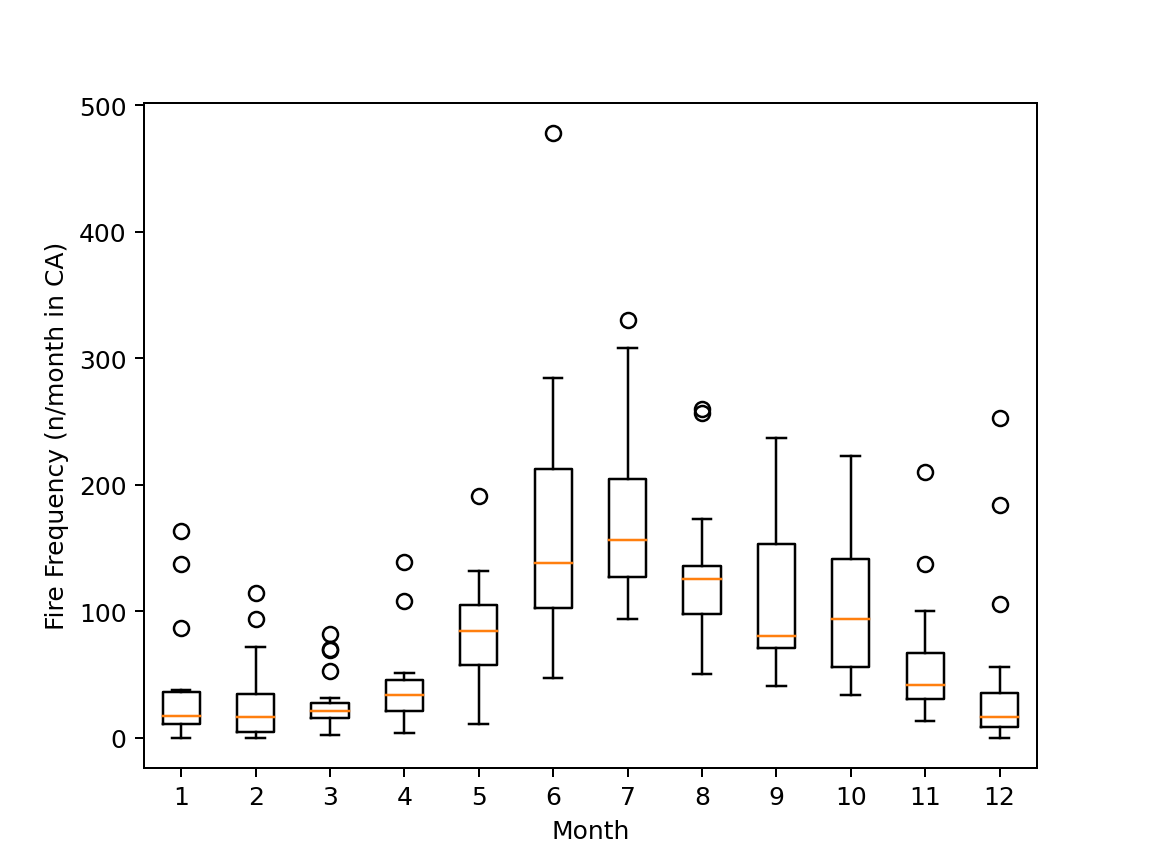

In [59]:
boxplot_data = []
for month in range(1,13):
    plot_data = []
    for year in range(2001, 2023):
        plot_data.append(len(fires.loc[(fires["YEAR"] == year) & (fires["MONTH"] == month)]))
    boxplot_data.append(plot_data)

fig, ax = plt.subplots()
ax.boxplot(boxplot_data)
ax.set_xlabel("Month")
ax.set_ylabel("Fire Frequency (n/month in CA)")
plt.show()

<IPython.core.display.Javascript object>


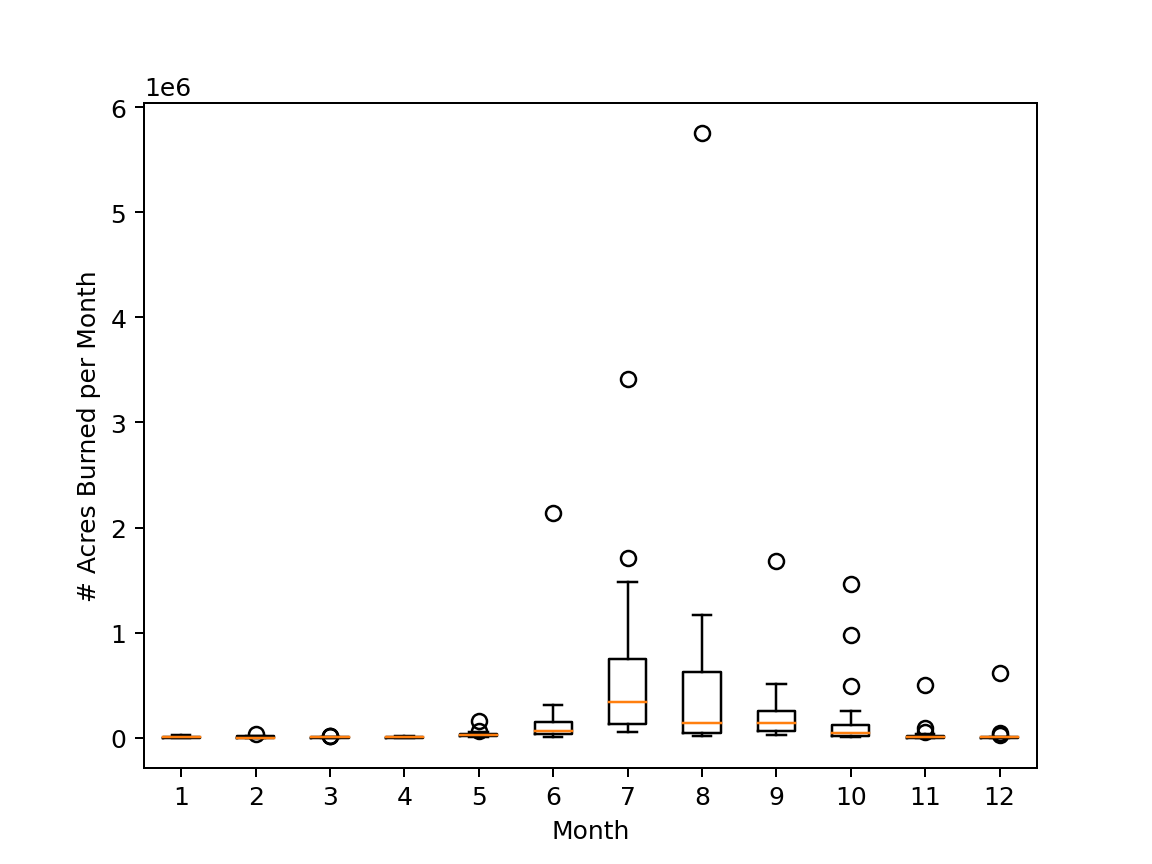

In [60]:
boxplot_data = []
for month in range(1,13):
    plot_data = []
    for year in range(2001, 2023):
        plot_data.append(np.sum(fires.loc[(fires["YEAR"] == year) & (fires["MONTH"] == month)]["GIS_ACRES"]))
    boxplot_data.append(plot_data)

fig, ax = plt.subplots()
ax.boxplot(boxplot_data)
ax.set_xlabel("Month")
ax.set_ylabel("# Acres Burned per Month")
plt.show()

In [71]:
fires_select = fires.loc[(fires["YEAR"] >= 2001) & (fires["YEAR"] <= 2022) & (fires["MONTH"] >= 7) & (fires["MONTH"] <= 8)]

In [64]:
len(fires_select)

6578

<IPython.core.display.Javascript object>


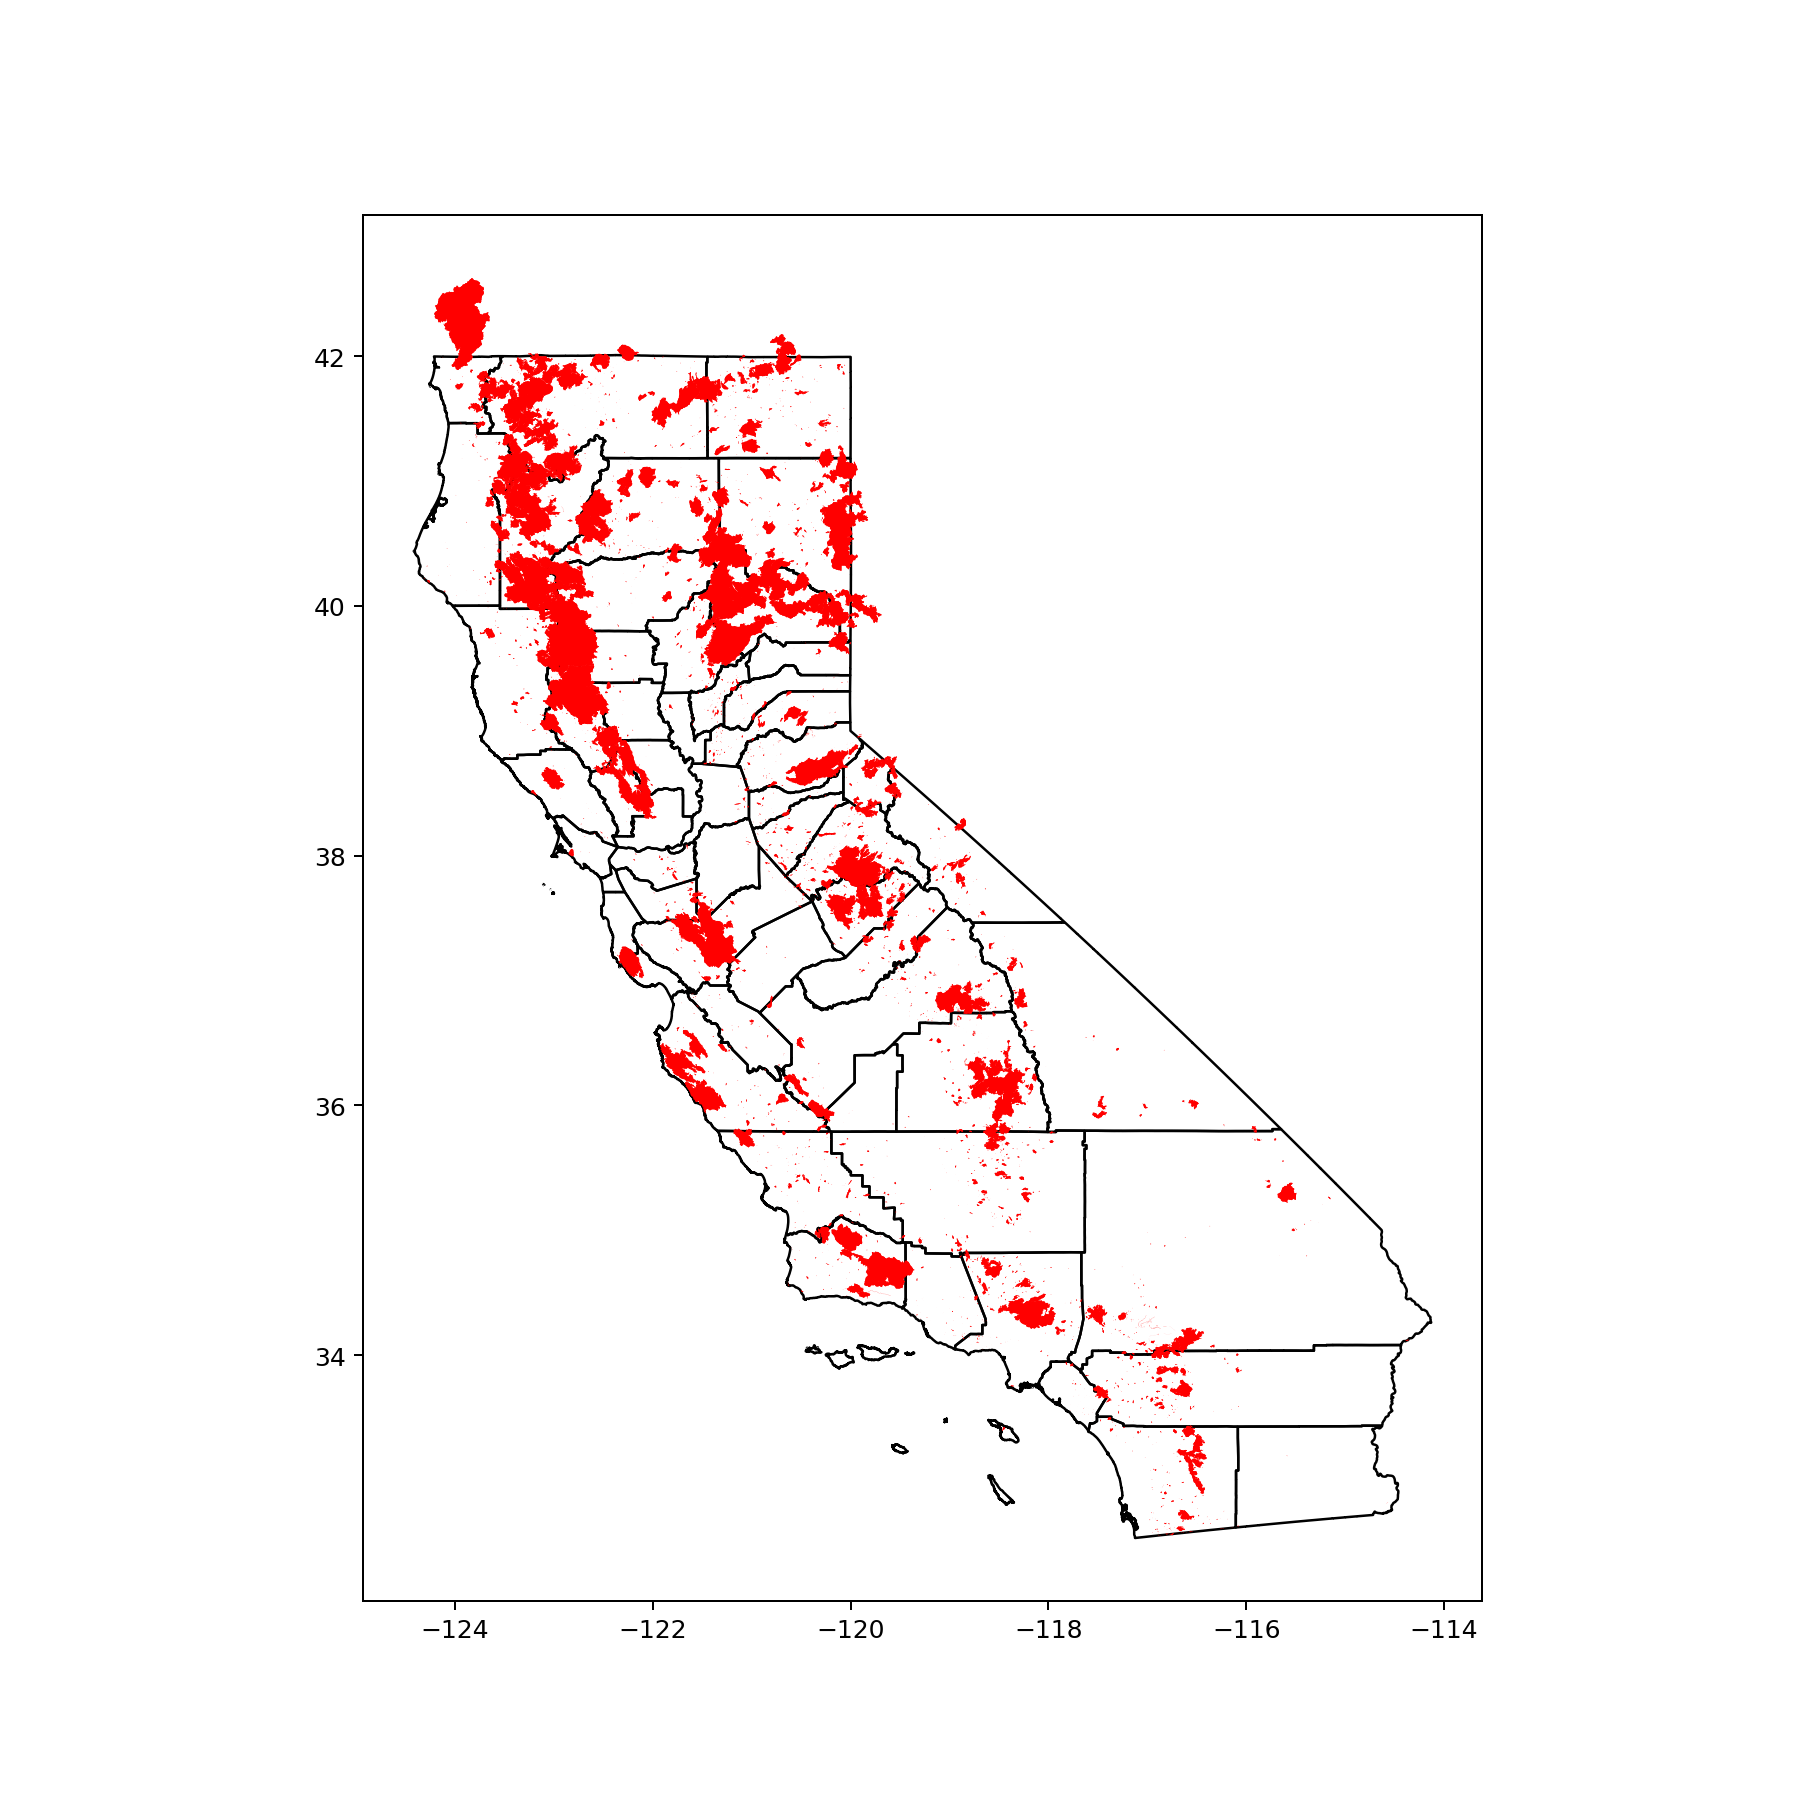

<Axes: >

In [72]:
%matplotlib notebook
ax = world.plot(color = "none",edgecolor = 'black', figsize = (10,10))
fires_select.plot(ax = ax, color = "red")

<IPython.core.display.Javascript object>


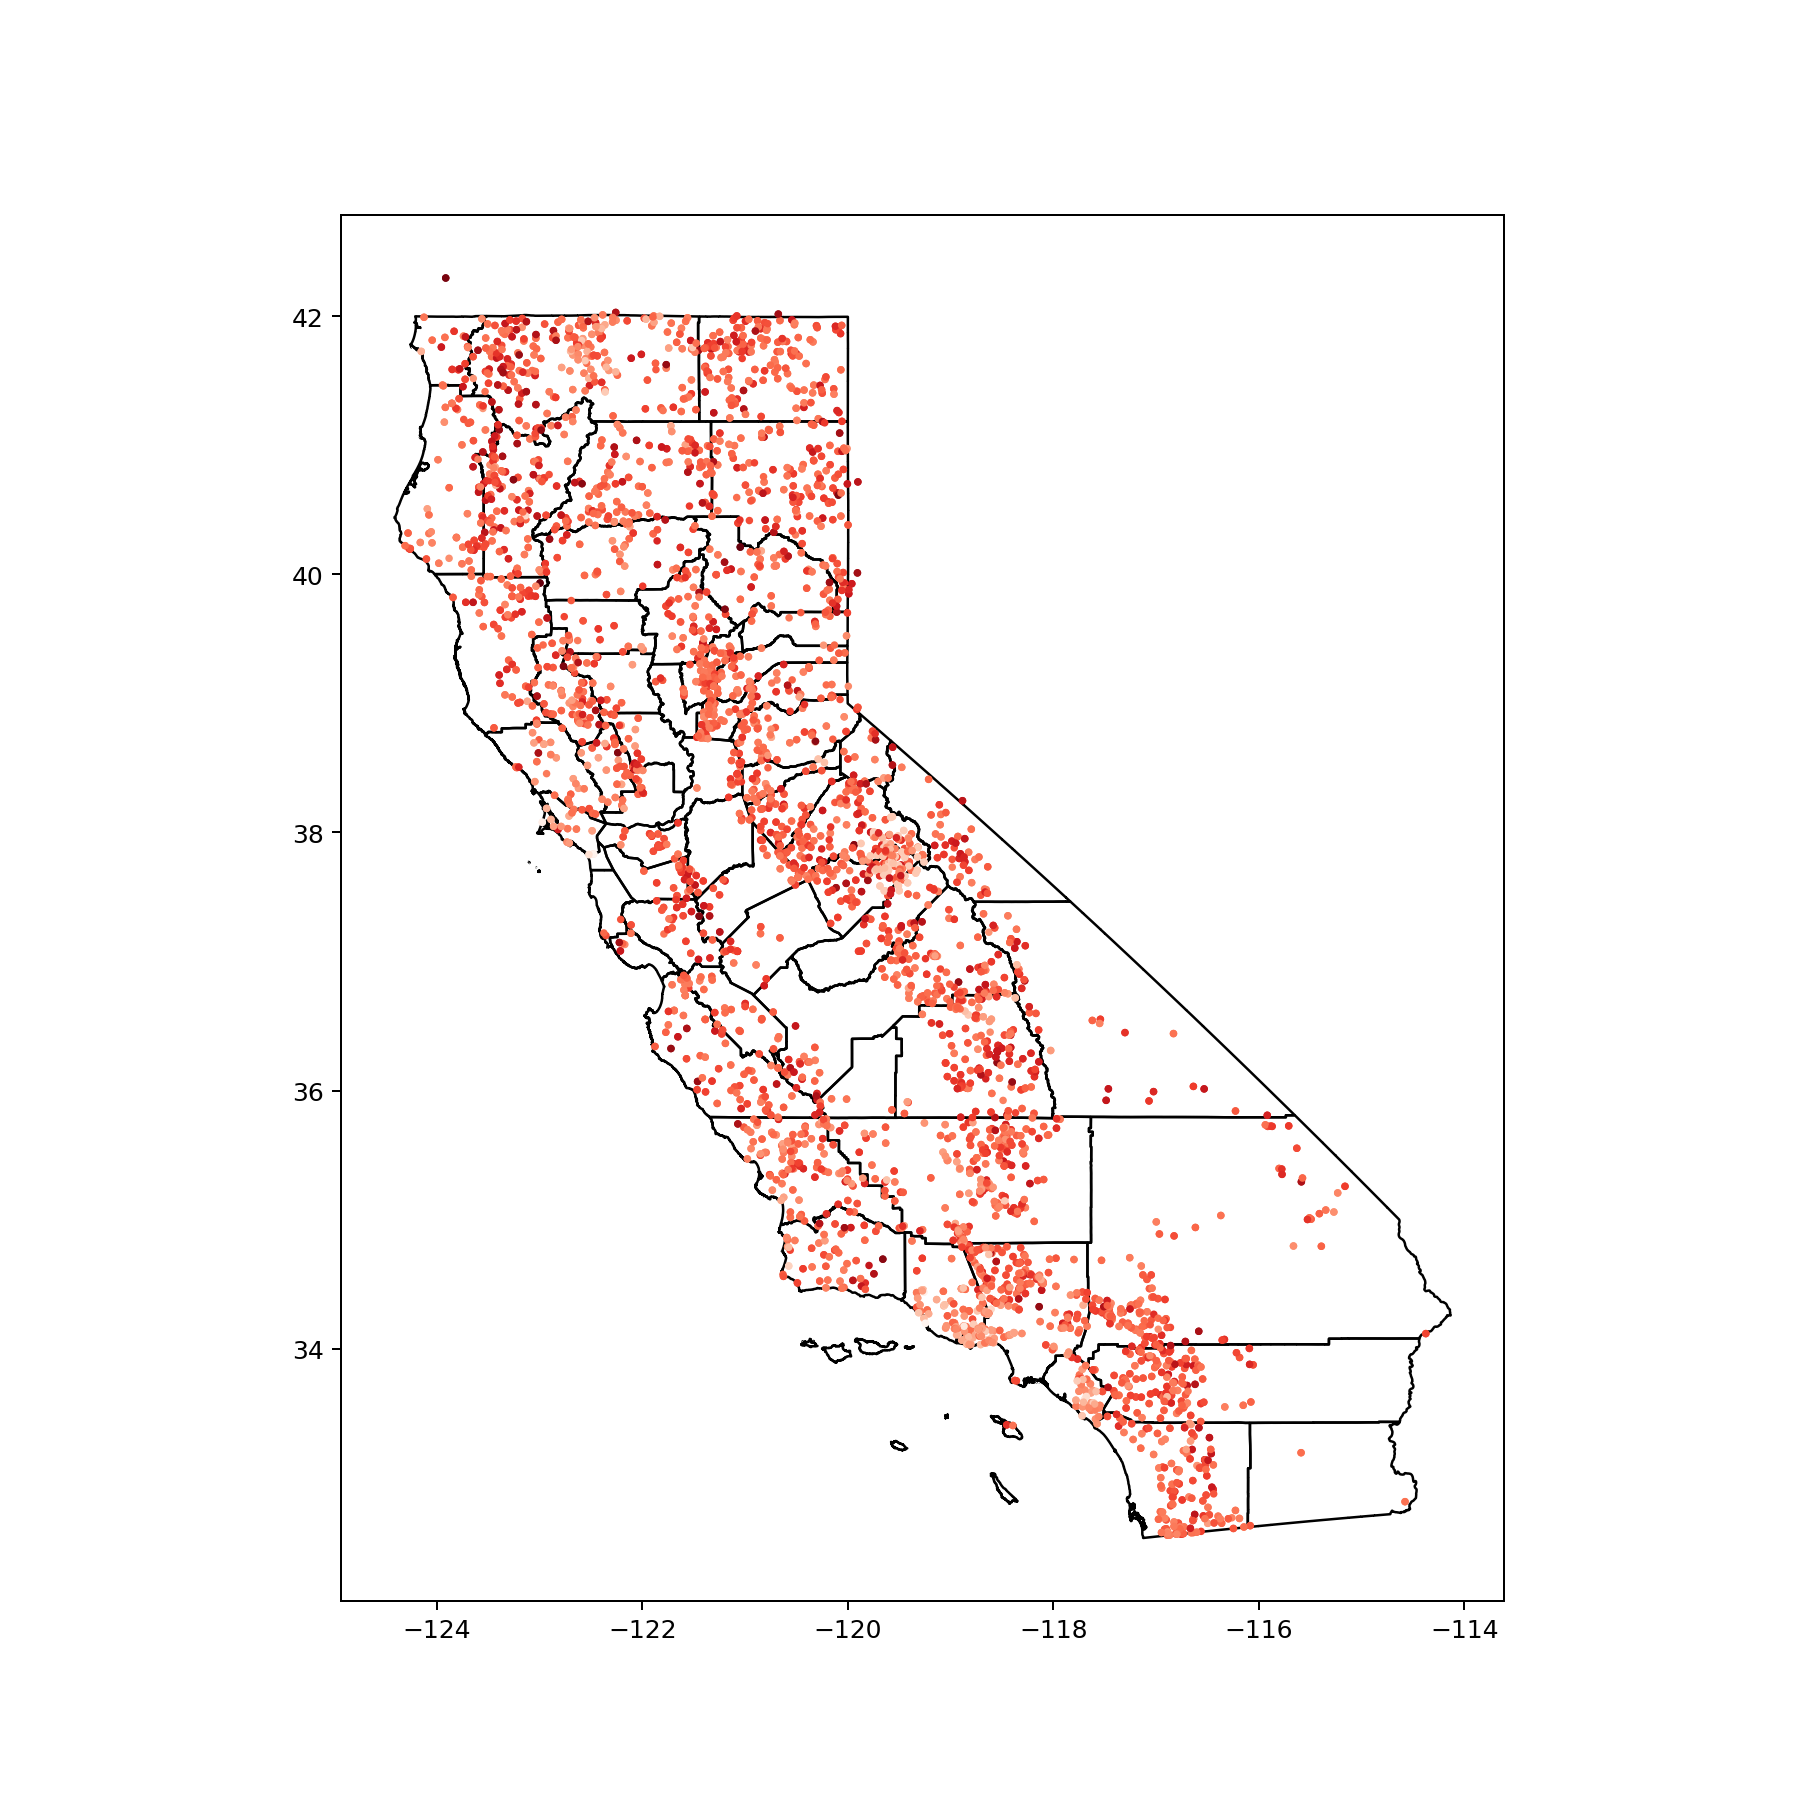

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_34693/548704328.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ax.scatter(fires_select["geometry"].centroid.x, fires_select["geometry"].centroid.y, cmap = "Reds", c = np.log(fires_select["GIS_ACRES"]), s=4)


In [73]:
%matplotlib notebook
ax = world.plot(color = "none",edgecolor = 'black', figsize = (10,10))
ax.scatter(fires_select["geometry"].centroid.x, fires_select["geometry"].centroid.y, cmap = "Reds", c = np.log(fires_select["GIS_ACRES"]), s=4)

In [74]:
len(fires_select)

6578

In [75]:
#################################################
###### TAKES A LONG TIME TO RUN BE CAREFUL ######
#################################################

xmin, ymin, xmax, ymax= (-125, 32, -113, 43)
n_cells=828
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = fires.crs
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = geopandas.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)
cell = cell.clip(world)

/Users/christopher/anaconda3/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Index(['geometry', 'interpolated_value', 'idw_interpolate_normal',
       'kriging_kernel_none_normal'],
      dtype='object')

In [114]:
def plotter():
    ax = cell.plot(column='interpolated_value', figsize=(12, 8), cmap='plasma', legend=True)
    world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (12,8))
def log_plotter():
    ax = cell.plot(column='interpolated_value', figsize=(12, 8), cmap='plasma', norm=colors.SymLogNorm(linthresh = 0.2), legend=True)
    world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (12,8))

In [120]:
# cell["geometry"].to_pickle("./dataframes/cell_geometry")

In [96]:
'''
█ █▄░█ █░█ █▀▀ █▀█ █▀ █▀▀   █▀▄ █ █▀ ▀█▀ ▄▀█ █▄░█ █▀▀ █▀▀   █░█░█ █▀▀ █ █▀▀ █░█ ▀█▀ █▀▀ █▀▄
█ █░▀█ ▀▄▀ ██▄ █▀▄ ▄█ ██▄   █▄▀ █ ▄█ ░█░ █▀█ █░▀█ █▄▄ ██▄   ▀▄▀▄▀ ██▄ █ █▄█ █▀█ ░█░ ██▄ █▄▀'''

def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536> 
    """
    
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    
    # calculate hypotenuse
    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation 
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """
    
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)
    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)
def grid_idw(points, values, xi):
    if (len(points) != len(values)):
        raise ValueError
    return simple_idw(points.T[0], points.T[1], values, cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)


In [121]:
points = np.array((fires_select["geometry"].centroid.x, fires_select["geometry"].centroid.y)).T
values = np.array(fires_select['GIS_ACRES'])
xi = np.array((cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)).T

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_34693/2171924977.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = np.array((fires_select["geometry"].centroid.x, fires_select["geometry"].centroid.y)).T
/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_34693/2171924977.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xi = np.array((cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)).T


In [122]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(points, values, xi, method='linear')
cell["interpolated_value"].to_pickle("./dataframes/linear_interpolation_normal")
# plotter()

In [123]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(points, values, xi, method='cubic')
cell["interpolated_value"].to_pickle("./dataframes/cubic_interpolation_normal")
# plotter()

In [124]:
cell["interpolated_value"] = grid_idw(points, values, xi)
cell["interpolated_value"].to_pickle("./dataframes/idw_interpolation_normal")

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_34693/2661542495.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return simple_idw(points.T[0], points.T[1], values, cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)


In [125]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel
gpr = GaussianProcessRegressor(kernel=None, random_state=0).fit(points, values)
cell["interpolated_value"] = gpr.predict(xi)
cell["interpolated_value"].to_pickle("./dataframes/kriging_kernel_none_normal")

In [134]:
from sklearn.gaussian_process.kernels import RBF
gpr2 = GaussianProcessRegressor(kernel=RBF(1.0), random_state=0).fit(points, values)
cell["interpolated_value"] = gpr2.predict(xi)
cell["interpolated_value"].to_pickle("./dataframes/kriging_kernel_RBF_1_normal")

/Users/christopher/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [127]:
# log_plotter()

In [128]:
points = np.array((fires_select["geometry"].centroid.x, fires_select["geometry"].centroid.y)).T
values = np.log(np.array(fires_select['GIS_ACRES']))
xi = np.array((cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)).T

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_34693/3486649781.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = np.array((fires_select["geometry"].centroid.x, fires_select["geometry"].centroid.y)).T
/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_34693/3486649781.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xi = np.array((cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)).T


In [129]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(points, values, xi, method='linear')
cell["interpolated_value"].to_pickle("./dataframes/linear_interpolation_log")
# plotter()

In [130]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(points, values, xi, method='cubic')
cell["interpolated_value"].to_pickle("./dataframes/cubic_interpolation_log")
# plotter()

In [131]:
cell["interpolated_value"] = grid_idw(points, values, xi)
cell["interpolated_value"].to_pickle("./dataframes/idw_interpolation_log")
# plotter()

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_34693/2661542495.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return simple_idw(points.T[0], points.T[1], values, cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)


In [132]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel
gpr = GaussianProcessRegressor(kernel=None, random_state=0).fit(points, values)
cell["interpolated_value"] = gpr.predict(xi)
cell["interpolated_value"].to_pickle("./dataframes/kriging_kernel_none_log")

In [133]:
from sklearn.gaussian_process.kernels import RBF
gpr2 = GaussianProcessRegressor(kernel=RBF(1.0), random_state=0).fit(points, values)
cell["interpolated_value"] = gpr2.predict(xi)
cell["interpolated_value"].to_pickle("./dataframes/kriging_kernel_RBF_1_log")

/Users/christopher/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:

ax = cell.plot(column='interpolated_value', figsize=(12, 8), norm=colors.LogNorm(vmin=cell["interpolated_value"].min(), vmax=cell["interpolated_value"].max()), cmap='inferno', legend=True)
plt.autoscale(False)
world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (12,8))

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_91960/2149588891.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return simple_idw(points.T[0], points.T[1], values, cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)


In [ ]:
# choose = []
# for i in fires.index:
#     if (fires["START_DATE"].notnull()[i]):
#         if (str(fires["START_DATE"][i]).split("-")[0] >= "2000" and int(str(fires["START_DATE"][i]).split("-")[1]) == 7):
#             choose.append(True)
#         else:
#             choose.append(False)
#     else:
#         try:
#             if (str(fires["ALARM_DATE"][i]).split("-")[0] >= "2000" and int(str(fires["ALARM_DATE"][i]).split("-")[1]) == 7):
#                 choose.append(True)
#             else:
#                 choose.append(False)
#         except:
# #             print(fires["ALARM_DATE"][i])
#             choose.append(False)

In [34]:
for filename in filenames:
    print("\n\n\n\nFILENAME:" + filename)
    fires = geopandas.read_file(filename)
    print(fires.head())





FILENAME:./fire22_1.gdb/a0000007f.gdbtable
                                     UUID  \
0  {C29DA988-8C3E-45F7-8B5C-18E51EE7BEB4}   
1  {CD06BC3B-789D-4C51-AAFA-A467912B8965}   
2  {DB1B697A-3BB6-426A-98A2-6EE7A4C6AED3}   
3  {FFD09C28-FE70-4E25-907C-AF8E8A5EC5F3}   
4  {74737149-DCB5-4257-8904-B9724E32A530}   

                             ParentTypeID             Name geometry  
0  {8637F1ED-8C04-4866-A44A-1CB8288B3C63}     Range Domain     None  
1  {D4912162-3413-476E-9DA4-2AEFBBC16939}            Table     None  
2  {28DA9E89-FF80-4D6D-8926-4EE2B161677D}          Toolbox     None  
3  {8405ADD5-8DF8-4227-8FAC-3FCADE073386}         Resource     None  
4  {28DA9E89-FF80-4D6D-8926-4EE2B161677D}  Feature Dataset     None  




FILENAME:./fire22_1.gdb/a00000080.gdbtable
                                     UUID  \
0  {A5762059-A204-43D9-978A-09221033766B}   
1  {F06378B6-5A0C-4B4F-90FC-D026239573BF}   
2  {376DE1D0-7049-413E-B06B-423D648D328D}   
3  {360FF1F2-C06E-4D10-869C-2F0BD48

  YEAR_ STATE AGENCY UNIT_ID TREATMENT_ID         TREATMENT_NAME  \
0  2020    CA    CDF     AEU        10509  Jan 31 2020 Broadcast   
1  2020    CA    PVT     AEU        10572   2020 Fuels Reduction   
2  2020    CA    CDF     AEU        10630     Feb 2020 Broadcast   
3  2020    CA    CDF     AEU        10639     Feb 2020 Broadcast   
4  2020    CA    CDF     AEU        10780   Mar 3 2020 Broadcast   

                 START_DATE                   END_DATE  TREATED_AC  GIS_ACRES  \
0 2020-01-31 00:00:00+00:00  2020-01-31T00:00:00+00:00        15.0  15.047042   
1 2020-02-13 00:00:00+00:00  2020-02-13T00:00:00+00:00        22.3  36.739700   
2 2020-02-13 00:00:00+00:00  2020-02-18T00:00:00+00:00        22.4  38.839832   
3 2020-02-11 00:00:00+00:00  2020-02-20T00:00:00+00:00        75.5  75.498100   
4 2020-03-03 00:00:00+00:00  2020-03-03T00:00:00+00:00        61.8  61.771519   

   RX_CONSUM  PRE_CON_CLASS  POST_CON_CLASS  TREATMENT_TYPE  Shape_Length  \
0        NaN            NaN